In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy, collections 
import matplotlib as mpl
import matplotlib.pyplot as plt

import os, re, glob, time
import itertools, collections
import librosa, pickle

import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

random_state = 2020
sns.set( palette='cubehelix')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

## Load the JSON files

In [2]:
#directory to training data and json file
train_dir='../Data_large/nsynth-train/examples.json'
#directory to training data and json file
valid_dir='../Data_large/nsynth-valid/examples.json'
#directory to training data and json file
test_dir='../Data_large/nsynth-test/examples.json'

In [3]:
#load the json files
df_train= pd.read_json(train_dir, orient='index')
df_valid= pd.read_json(valid_dir, orient='index')
df_test= pd.read_json(test_dir, orient='index')

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
guitar_acoustic_001-082-050,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
bass_synthetic_120-108-050,168243,16000,108,2,bass,bass_synthetic_120,bass_synthetic_120-108-050,[percussive],synthetic,50,0,881,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
organ_electronic_120-050-127,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
guitar_electronic_021-026-025,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"[fast_decay, percussive]",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
organ_electronic_011-079-075,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Feature Distribution

### Instrument Families

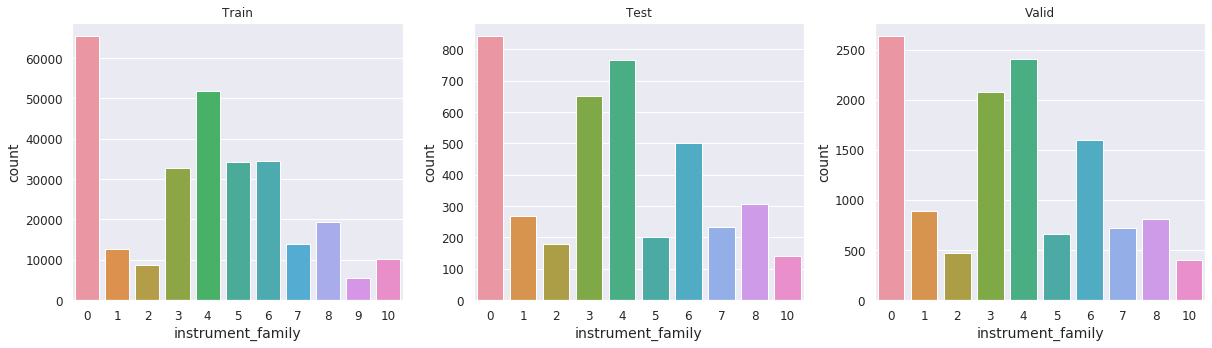

In [12]:
f, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.countplot(x='instrument_family', data = df_train, ax = axes[0]).set_title('Train')
sns.countplot(x='instrument_family', data = df_test, ax = axes[1]).set_title('Test')
sns.countplot(x='instrument_family', data = df_valid, ax = axes[2]).set_title('Valid')

plt.tight_layout()

plt.show()

### Instrument Source

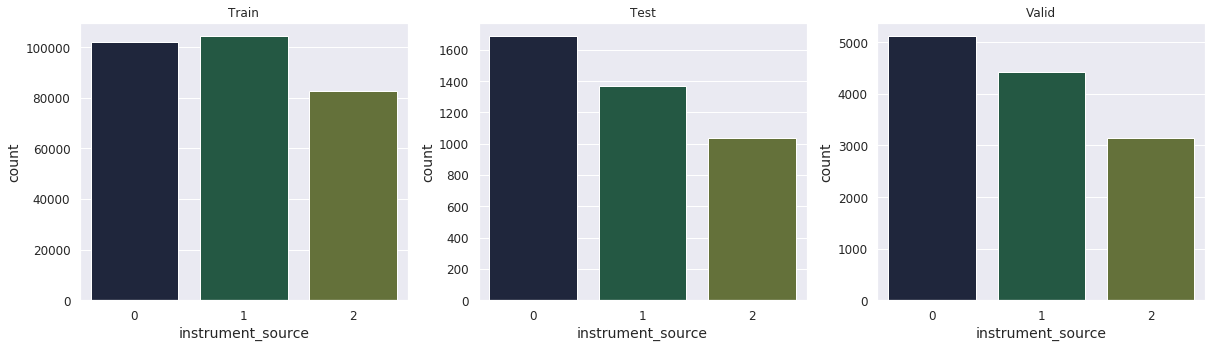

In [13]:
f, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.countplot(x='instrument_source', data = df_train, ax = axes[0]).set_title('Train')
sns.countplot(x='instrument_source', data = df_test, ax = axes[1]).set_title('Test')
sns.countplot(x='instrument_source', data = df_valid, ax = axes[2]).set_title('Valid')

plt.tight_layout()

plt.show()

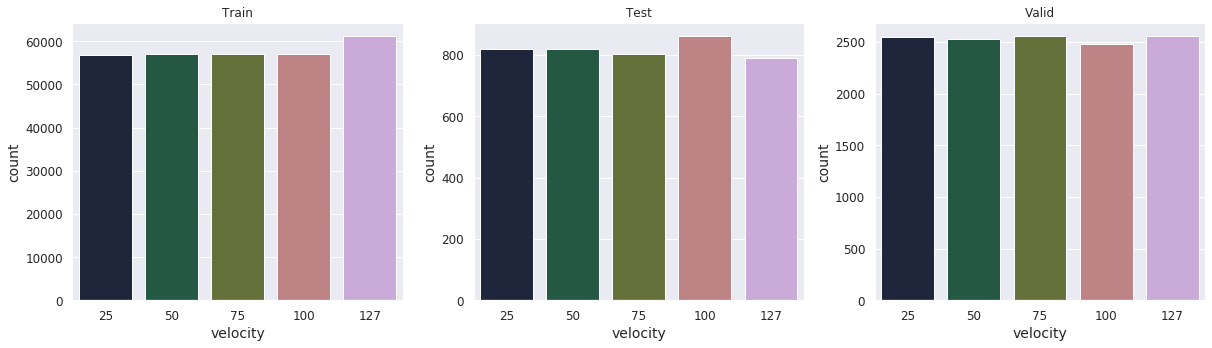

In [14]:
f, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.countplot(x='velocity', data = df_train, ax = axes[0]).set_title('Train')
sns.countplot(x='velocity', data = df_test, ax = axes[1]).set_title('Test')
sns.countplot(x='velocity', data = df_valid, ax = axes[2]).set_title('Valid')

plt.tight_layout()

plt.show()

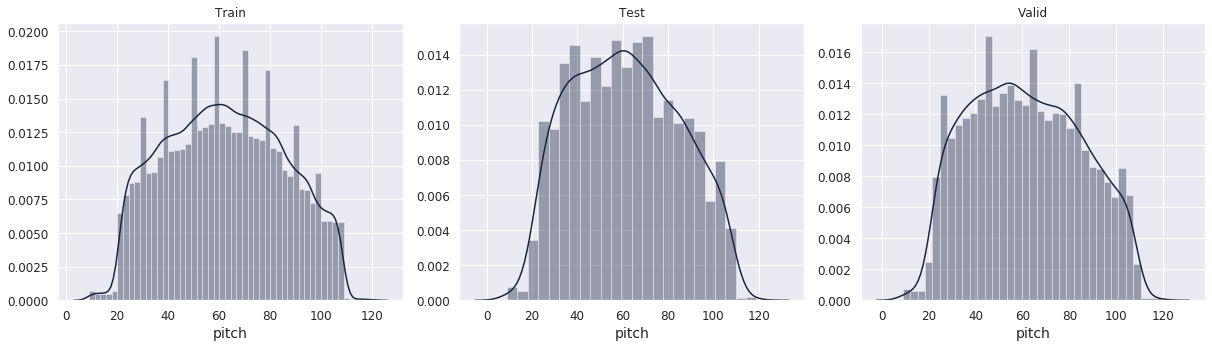

In [15]:
f, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.distplot(df_train.pitch, ax = axes[0]).set_title('Train')
sns.distplot(df_test.pitch, ax = axes[1]).set_title('Test')
sns.distplot(df_valid.pitch, ax = axes[2]).set_title('Valid')

plt.tight_layout()

plt.show()

### Statistics

In [16]:
df_train.describe()

,note,sample_rate,pitch,instrument_source,velocity,instrument_family,instrument
count,289205.000000,289205.0,289205.000000,289205.000000,289205.000000,289205.000000,289205.000000
mean,153095.048277,16000.0,62.311658,0.932370,76.172504,3.866462,490.943127
std,88232.549732,0.0,23.082522,0.796443,36.181410,2.843398,280.813189
min,0.000000,16000.0,9.000000,0.000000,25.000000,0.000000,0.000000
25%,76755.000000,16000.0,44.000000,0.000000,50.000000,1.000000,247.000000
50%,153254.000000,16000.0,62.000000,1.000000,75.000000,4.000000,499.000000
75%,229461.000000,16000.0,80.000000,2.000000,100.000000,6.000000,732.000000
max,305978.000000,16000.0,120.000000,2.000000,127.000000,10.000000,1005.000000


In [17]:
df_valid.describe()

,sample_rate,instrument_source,instrument_family,note,pitch,instrument,velocity
count,12678.0,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000
mean,16000.0,0.843193,3.642530,151895.227638,61.529894,435.214308,75.334516
std,0.0,0.791823,2.717627,89869.132754,23.543176,302.248923,35.996326
min,16000.0,0.000000,0.000000,8.000000,9.000000,8.000000,25.000000
25%,16000.0,0.000000,1.000000,72977.250000,42.000000,123.000000,50.000000
50%,16000.0,1.000000,4.000000,149368.500000,60.000000,417.000000,75.000000
75%,16000.0,1.000000,6.000000,230152.250000,80.000000,656.000000,100.000000
max,16000.0,2.000000,10.000000,305977.000000,120.000000,958.000000,127.000000


In [18]:
df_test.describe()

,pitch,note,velocity,instrument,sample_rate,instrument_source,instrument_family
count,4096.000000,4096.000000,4096.000000,4096.000000,4096.0,4096.000000,4096.000000
mean,61.480713,149040.895752,75.288574,423.497070,16000.0,0.840332,3.704590
std,23.386504,90014.146997,35.775118,300.198066,0.0,0.799813,2.761171
min,9.000000,87.000000,25.000000,8.000000,16000.0,0.000000,0.000000
25%,42.000000,70077.500000,50.000000,123.000000,16000.0,0.000000,1.000000
50%,61.000000,143984.500000,75.000000,417.000000,16000.0,1.000000,4.000000
75%,80.000000,228438.000000,100.000000,656.000000,16000.0,2.000000,6.000000
max,119.000000,305832.000000,127.000000,958.000000,16000.0,2.000000,10.000000
